In [114]:
# Data Processing
import pandas as pd
import numpy as np

# Modelling
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn import linear_model, metrics
from sklearn.model_selection import train_test_split
from mlxtend.feature_selection import SequentialFeatureSelector as SFS
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.preprocessing import StandardScaler

import statsmodels.api as sm
import statsmodels.formula.api as smf
from sklearn.datasets import make_regression

# Tree Visualisation
from sklearn.tree import export_graphviz
from IPython.display import Image
import graphviz

# Plotting
import matplotlib.pyplot as plt
import seaborn as sns

In [115]:
imfd = '$_{fd}^{im}$RMSD'

### Read in all of our data

In [116]:
nstds = pd.read_csv('./project_pipeline/data/ai_nonstandard_monomers.tsv', sep='\t')
hydro = pd.read_csv('./project_pipeline/data/ai_hydrophobic_residues.tsv', sep='\t')
interpro = pd.read_csv('./project_pipeline/data/interpro.tsv', sep='\t')
interfaces = pd.read_csv('./project_pipeline/data/proteins_interface.tsv', sep='\t')

### Trim it down

In [117]:
nstds.head()

,uniprot,pdb,region_1,region_2,complex_rmsd,percent_region_1,percent_region_2,2_aligned,2_comp,state,...,date,notes,chain,af_filename,nstds,non-polymers,has_partner,num_partners,has_nstds,has_nplymrs
0,P04637,8f2h,364-393,102-292,30.431,100.0,100.0,3.065,70.729,Autoinhibited,...,['2022-11-08'],NaN,A,F-P04637-F1-model_v3.cif,[],[],False,0,False,False
1,P04637,8f2i,364-393,102-292,30.431,100.0,100.0,3.065,70.729,Autoinhibited,...,['2022-11-08'],NaN,A,F-P04637-F1-model_v3.cif,[],[],False,0,False,False
2,P07038,1mhs,892-917,562-625,14.225,100.0,100.0,8.246,22.815,Active,...,['2002-08-21'],NaN,A,F-P07038-F1-model_v3.cif,[],[],False,0,False,False
3,P07038,7nxf,892-917,562-625,4.914,100.0,100.0,1.812,12.107,Autoinhibited,...,['2021-03-18'],“Phosphorylation of Ser913/Thr914 would distur...,A,F-P07038-F1-model_v3.cif,"[""ADENOSINE-5'-DIPHOSPHATE""]","['POTASSIUM ION', 'MAGNESIUM ION']",False,0,True,True
4,P07038,7ny1,892-917,562-625,4.914,100.0,100.0,1.812,12.107,Autoinhibited,...,['2021-03-19'],NaN,A,F-P07038-F1-model_v3.cif,"[""ADENOSINE-5'-DIPHOSPHATE""]","['POTASSIUM ION', 'MAGNESIUM ION']",False,0,True,True


In [118]:
nstds = nstds[['uniprot', 'pdb', 'complex_rmsd', '2_comp', 'nstds', 'non-polymers', 'has_partner', 'num_partners', 'has_nstds', 'has_nplymrs']]

In [119]:
hydro.head()

,Unnamed: 0,uniprot,af_filename,region_1,region_2,num_hydrophobic,percent_hydrophobic
0,0,P04637,F-P04637-F1-model_v3.cif,364-393,102-292,87,0.394
1,1,P07038,F-P07038-F1-model_v3.cif,892-917,562-625,43,0.478
2,2,Q8NQJ3,F-Q8NQJ3-F1-model_v3.cif,1-40,68-117,38,0.422
3,3,P00579,F-P00579-F1-model_v3.cif,2-80,"379-449,458-534",104,0.458
4,4,P60240,F-P60240-F1-model_v3.cif,1-110,"147-416,441-659",294,0.491


In [120]:
hydro = hydro[['uniprot', 'num_hydrophobic', 'percent_hydrophobic']]

In [121]:
interpro.head()

,uniprot,pdb,region_1,region_2,complex_rmsd,percent_region_1,percent_region_2,2_aligned,2_comp,conformation,...,date,notes,domain,homologous_superfamily,family,active_site,conserved_site,repeat,binding_site,ptm
0,A0A0R4I961,6gtv,155-279,3-147,1.450,100.0,100.000000,1.673,1.135,Open,...,['2018-06-19'],NaN,"Fimbrial-type adhesion domain, FimH, mannose-b...","Adhesion domain superfamily, Fimbrial-type adh...",NaN,NaN,NaN,NaN,NaN,NaN
1,A0A0R4I961,6gtz,155-279,3-147,1.631,100.0,100.000000,1.648,3.014,Open,...,['2018-06-19'],NaN,"Fimbrial-type adhesion domain, FimH, mannose-b...","Adhesion domain superfamily, Fimbrial-type adh...",NaN,NaN,NaN,NaN,NaN,NaN
2,A0A0R4I961,6gu0,155-279,3-147,2.105,100.0,100.000000,1.788,4.298,Open,...,['2018-06-19'],NaN,"Fimbrial-type adhesion domain, FimH, mannose-b...","Adhesion domain superfamily, Fimbrial-type adh...",NaN,NaN,NaN,NaN,NaN,NaN
3,B5XAZ0,7bfk,116-120,1-115,4.781,100.0,83.478261,2.600,0.965,Closed,...,['2021-01-04'],NaN,Ribonuclease A-domain,Ribonuclease A-like domain superfamily,Pancreatic ribonuclease,"Ribonuclease A, active site",NaN,NaN,NaN,NaN
4,B5XAZ0,7bfl,116-120,1-115,2.591,100.0,79.130435,2.760,0.807,Closed,...,['2021-01-04'],NaN,Ribonuclease A-domain,Ribonuclease A-like domain superfamily,Pancreatic ribonuclease,"Ribonuclease A, active site",NaN,NaN,NaN,NaN


In [122]:
interpro = interpro[['uniprot', 'homologous_superfamily', 'family', 'active_site', 'conserved_site', 'repeat', 'binding_site', 'ptm']].drop_duplicates().reset_index(drop=True)

In [123]:
interfaces.head()

,uniprot,region_1,region_2,region_1_len,region_2_len,pdb,pdb_length,resolution,model,chain,...,percent_region_2,gt_fn,af_filename,pdb_mutations,interacting_residue_pairs,interface_residues,number_interface_residues,region_1 search,region_2 search,Keep
0,P04637,364-393,102-292,30,191,8f2h,393,2.50,0,A,...,100.000000,8f2h.cif,F-P04637-F1-model_v3.cif,?,"[(148, 366), (271, 375), (148, 367), (104, 370...","{269, 271, 148, 164, 102, 103, 104, 106, 107, ...",21.0,"[364, 365, 366, 367, 368, 369, 370, 371, 372, ...","[102, 103, 104, 105, 106, 107, 108, 109, 110, ...",True
1,P04637,364-393,102-292,30,191,8f2i,393,2.50,0,A,...,100.000000,8f2i.cif,F-P04637-F1-model_v3.cif,NaN,"[(104, 368), (164, 375), (110, 369), (102, 370...","{269, 271, 148, 164, 102, 103, 104, 106, 107, ...",21.0,"[364, 365, 366, 367, 368, 369, 370, 371, 372, ...","[102, 103, 104, 105, 106, 107, 108, 109, 110, ...",NaN
2,P00523,"148-245,246-266","81-142,521-533",119,75,2ptk,425,2.35,0,A,...,89.333333,2ptk.cif,F-P00523-F1-model_v3.cif,?,"[(117, 253), (95, 254), (96, 256), (118, 255),...","{256, 257, 131, 133, 135, 136, 524, 526, 528, ...",33.0,"[148, 149, 150, 151, 152, 153, 154, 155, 156, ...","[128, 129, 130, 131, 132, 133, 134, 135, 136, ...",True
3,P28482,173-196,"25-172,197-313",24,265,1pme,328,2.00,0,A,...,96.603774,1pme.cif,F-P28482-F1-model_v3.cif,"PENTA MUTANT I103L, Q105T, D106H, E109G, T110A","[(181, 201), (148, 189), (149, 189), (193, 209...","{256, 257, 259, 260, 263, 144, 145, 146, 148, ...",70.0,"[173, 174, 175, 176, 177, 178, 179, 180, 181, ...","[25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 3...",NaN
4,P28482,173-196,"25-172,197-313",24,265,1tvo,350,2.50,0,A,...,100.000000,1tvo.cif,F-P28482-F1-model_v3.cif,?,"[(184, 234), (191, 236), (183, 263), (176, 206...","{256, 257, 259, 260, 263, 144, 145, 146, 148, ...",68.0,"[173, 174, 175, 176, 177, 178, 179, 180, 181, ...","[25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 3...",NaN


In [124]:
interfaces = interfaces[['uniprot', 'number_interface_residues']]

### Merge all dataframes into one for analysis and explode columns.

In [125]:
ai = pd.merge(nstds, hydro, on='uniprot')
ai = pd.merge(ai, interpro, on='uniprot')
ai = pd.merge(ai, interfaces, on='uniprot')

In [126]:
ai.head()

,uniprot,pdb,complex_rmsd,2_comp,nstds,non-polymers,has_partner,num_partners,has_nstds,has_nplymrs,num_hydrophobic,percent_hydrophobic,homologous_superfamily,family,active_site,conserved_site,repeat,binding_site,ptm,number_interface_residues
0,P04637,8f2h,30.431,70.729,[],[],False,0,False,False,87,0.394,"p53-like transcription factor, DNA-binding dom...",p53 tumour suppressor family,NaN,NaN,NaN,NaN,NaN,21.0
1,P04637,8f2h,30.431,70.729,[],[],False,0,False,False,87,0.394,"p53-like transcription factor, DNA-binding dom...",p53 tumour suppressor family,NaN,NaN,NaN,NaN,NaN,21.0
2,P04637,8f2i,30.431,70.729,[],[],False,0,False,False,87,0.394,"p53-like transcription factor, DNA-binding dom...",p53 tumour suppressor family,NaN,NaN,NaN,NaN,NaN,21.0
3,P04637,8f2i,30.431,70.729,[],[],False,0,False,False,87,0.394,"p53-like transcription factor, DNA-binding dom...",p53 tumour suppressor family,NaN,NaN,NaN,NaN,NaN,21.0
4,P07038,1mhs,14.225,22.815,[],[],False,0,False,False,43,0.478,"P-type ATPase, A domain superfamily, HAD super...","P-type ATPase, P-type ATPase, subfamily IIIA",NaN,NaN,NaN,NaN,"P-type ATPase, phosphorylation site",18.0


One by one we're going to make a dataframe for the columns nstds, non-polymers, homologous_superfamily, and conserved site, and then select only those with 10 instances or greater and see what the multilinear correlations are between them.

In [151]:
def create_df(df, column):
    '''
    Take a dataframe and a column name and return a dataframe with only the rmsd values and the values in the column
    that occur at least ten times.
    '''

    df = df[['complex_rmsd', '2_comp', column]]
    df[column] = df[column].str.strip('][').str.split(', ')
    df = df.explode(column).reset_index(drop=True).replace('', np.nan).drop_duplicates().reset_index(drop=True)

    g10 = df[column].value_counts()[df[column].value_counts() > 10].index
    df = df[df[column].isin(g10)].reset_index(drop=True)

    return df

def encode_columns(df, column):
    '''
    Take a dataframe and a column name and return a dataframe with the column one hot encoded.
    '''
    df[column] = df[column].astype('category')
    df = pd.get_dummies(df, columns=[column], prefix='', prefix_sep='', dtype='float').reset_index(drop=True)
    return df

def stepwise_selection(X, y, 
                       initial_list=[], 
                       threshold_in=0.05, 
                       threshold_out=0.05, 
                       verbose=True):
    """
    Perform a forward-backward feature selection 
    based on p-values from statsmodels OLS.
    
    Parameters:
    -----------
    X : DataFrame
        Predictor variables
    y : Series or array-like
        Response variable (target)
    initial_list : list, optional
        List of features to start with (default is empty)
    threshold_in : float
        P-value threshold for adding a feature (default is 0.05)
    threshold_out : float
        P-value threshold for removing a feature (default is 0.05)
    verbose : bool
        Whether to print the progress of feature selection

    Returns:
    --------
    list : Selected features
    """
    included = list(initial_list)

    while True:
        changed = False
        
        # Forward Step
        excluded = list(set(X.columns) - set(included))
        new_pval = pd.Series(index=excluded)  # P-values for excluded vars
        for new_col in excluded:
            model = sm.OLS(y, sm.add_constant(X[included + [new_col]])).fit()
            new_pval[new_col] = model.pvalues[new_col]
        best_pval = new_pval.min()
        if best_pval < threshold_in:
            best_feature = new_pval.idxmin()
            included.append(best_feature)
            changed = True
            if verbose:
                print(f'Add  {best_feature} with p-value {best_pval:.6f}')

        # Backward Step
        model = sm.OLS(y, sm.add_constant(X[included])).fit()
        pvalues = model.pvalues.iloc[1:]  # Ignore intercept p-value
        worst_pval = pvalues.max()  # Worst p-value among included features
        if worst_pval > threshold_out:
            worst_feature = pvalues.idxmax()
            included.remove(worst_feature)
            changed = True
            if verbose:
                print(f'Remove {worst_feature} with p-value {worst_pval:.6f}')

        if not changed:
            break

    return included

def df_features(df):
    '''
    Take a dataframe and a column name and return the features and target variable.
    '''
    X = df.drop(['complex_rmsd', '2_comp'], axis=1)
    y1 = df['complex_rmsd']
    y2 = df['2_comp']

    selected_features1 = stepwise_selection(X, y1)
    selected_features2 = stepwise_selection(X, y2)

    return selected_features1, selected_features2

def fit_model(df, features1, features2):
    y1 = df['complex_rmsd']
    y2 = df['2_comp']

    X1_selected = df[features1]
    X2_selected = df[features2]

    X1_train, X1_test, y1_train, y1_test = train_test_split(X1_selected, y1, test_size=0.2, random_state=42)
    X2_train, X2_test, y2_train, y2_test = train_test_split(X2_selected, y2, test_size=0.2, random_state=42)

    model1 = LinearRegression().fit(X1_train, y1_train)
    model2 = LinearRegression().fit(X2_train, y2_train)

    r_sq1 = model1.score(X1_train, y1_train)
    r_sq2 = model2.score(X2_train, y2_train)

    y1_pred = model1.predict(X1_test)
    y2_pred = model2.predict(X2_test)

    y1_test = y1_test.values.flatten()
    y2_test = y2_test.values.flatten()

    df1 = pd.DataFrame({'feature': X1_selected.columns, 'coefficient': model1.coef_})
    df2 = pd.DataFrame({'feature': X2_selected.columns, 'coefficient': model2.coef_})

    df3 = pd.DataFrame({'Actual': y1_test, 'Predicted': y1_pred})
    df4 = pd.DataFrame({'Actual': y2_test, 'Predicted': y2_pred})

    return df1, df2, df3, df4

def fit_logistic_model(df, features1, features2):
    '''
    Fit a logistic model with 3 Angstroms as the cutoff for a good structure vs bad structure
    '''

    df['complex_fit'] = np.where(df['complex_rmsd'] <= 3, True, False).astype(int)
    df['imfd_fit'] = np.where(df['2_comp'] <= 3, True, False).astype(int)

    y1 = df['complex_fit']
    y2 = df['imfd_fit']

    X1_selected = df[features1]
    X2_selected = df[features2]

    X1_train, X1_test, y1_train, y1_test = train_test_split(X1_selected, y1, test_size=0.2, random_state=42)
    X2_train, X2_test, y2_train, y2_test = train_test_split(X2_selected, y2, test_size=0.2, random_state=42)

    model1 = LogisticRegression().fit(X1_train, y1_train)
    model2 = LogisticRegression().fit(X2_train, y2_train)

    y1_pred = model1.predict(X1_test)
    y2_pred = model2.predict(X2_test)

    cnf_matrix1 = metrics.confusion_matrix(y1_test, y1_pred)
    cnf_matrix2 = metrics.confusion_matrix(y2_test, y2_pred)

    target_names = ['incorrect_structure', 'correct_structure']

    report1 = metrics.classification_report(y1_test, y1_pred, target_names=target_names)
    report2 = metrics.classification_report(y2_test, y2_pred, target_names=target_names)

    return cnf_matrix1, cnf_matrix2, report1, report2


def plot_results(df1, df2, name):
    fig, ax = plt.subplots(2, 1, figsize=(6, 6))

    sns.regplot(x='Actual', y='Predicted', data=df1, ax=ax[0])

    sns.regplot(x='Actual', y='Predicted', data=df2, ax=ax[1])

    ax[0].set_title(name)

    plt.tight_layout()

def test_linear_model(X_test, y_test, model):
    y_pred = model.predict(X_test)
    accuracy = model.score(X_test, y_test)

    return accuracy

def plot_confusion_matrix(cnf_matrix):

    class_names=[0,1] # name  of classes
    fig, ax = plt.subplots()
    tick_marks = np.arange(len(class_names))
    plt.xticks(tick_marks, class_names)
    plt.yticks(tick_marks, class_names)
    # create heatmap
    sns.heatmap(pd.DataFrame(cnf_matrix), annot=True, cmap="YlGnBu" ,fmt='g')
    ax.xaxis.set_label_position("top")
    plt.tight_layout()
    plt.title('Confusion matrix', y=1.1)
    plt.ylabel('Actual label')
    plt.xlabel('Predicted label')

In [128]:
nstds = create_df(ai, 'nstds')
non_p = create_df(ai, 'non-polymers')
superfam = create_df(ai, 'homologous_superfamily')
fam = create_df(ai, 'family')
conserved = create_df(ai, 'conserved_site')

/tmp/ipykernel_639304/1077532895.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column] = df[column].str.strip('][').str.split(', ')
/tmp/ipykernel_639304/1077532895.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column] = df[column].str.strip('][').str.split(', ')
/tmp/ipykernel_639304/1077532895.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http

In [129]:
# Encode columns
enstds = encode_columns(nstds, 'nstds')
enon_p = encode_columns(non_p, 'non-polymers')
esuperfam = encode_columns(superfam, 'homologous_superfamily')
efam = encode_columns(fam, 'family')
econserved = encode_columns(conserved, 'conserved_site')

In [130]:
econserved.head()

,complex_rmsd,2_comp,Heat shock protein 70,Mitogen-activated protein (MAP) kinase,RING-type,Tyrosine-protein kinase,Zinc finger,conserved site,receptor class II
0,2.422,6.639,0.0,1.0,0.0,0.0,0.0,0.0,0.0
1,2.422,6.639,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2,2.497,6.633,0.0,1.0,0.0,0.0,0.0,0.0,0.0
3,2.497,6.633,0.0,0.0,0.0,0.0,0.0,1.0,0.0
4,2.515,6.306,0.0,1.0,0.0,0.0,0.0,0.0,0.0


We do the stepwise regression

In [131]:
enstds1, enstds2 = df_features(enstds)
enon_p1, enon_p2 = df_features(enon_p)
esuperfam1, esuperfam2 = df_features(esuperfam)
efam1, efam2 = df_features(efam)
econserved1, econserved2 = df_features(econserved)

Add  "GUANOSINE-5'-DIPHOSPHATE" with p-value 0.000000
Add  "GUANOSINE-5'-TRIPHOSPHATE" with p-value 0.000000
Add  "ADENOSINE-5'-DIPHOSPHATE" with p-value 0.000000
Add  'S,S-(2-HYDROXYETHYL)THIOCYSTEINE' with p-value 0.016116
Add  "GUANOSINE-5'-DIPHOSPHATE" with p-value 0.000000
Add  "GUANOSINE-5'-TRIPHOSPHATE" with p-value 0.000000
Add  "ADENOSINE-5'-DIPHOSPHATE" with p-value 0.000000
Add  'MAGNESIUM ION' with p-value 0.000000
Add  'PHOSPHOAMINOPHOSPHONIC ACID-GUANYLATE ESTER' with p-value 0.000000
Add  'CHLORIDE ION' with p-value 0.000000
Add  'GLYCEROL' with p-value 0.000002
Add  'ZINC ION' with p-value 0.000031
Add  'S-ADENOSYLMETHIONINE' with p-value 0.008589
Add  'SULFATE ION' with p-value 0.006193
Add  '1,2-ETHANEDIOL' with p-value 0.025517
Add  'MAGNESIUM ION' with p-value 0.000000
Add  'PHOSPHOAMINOPHOSPHONIC ACID-GUANYLATE ESTER' with p-value 0.000000
Add  'CHLORIDE ION' with p-value 0.000000
Add  'GLYCEROL' with p-value 0.000003
Add  'ZINC ION' with p-value 0.000049
Add  '1,2

In [153]:
nstds1, nstds2, nstds3, nstds4 = fit_model(enstds, enstds1, enstds2)
non_p1, non_p2, non_p3, non_p4 = fit_model(enon_p, enon_p1, enon_p2)
superfam1, superfam2, superfam3, superfam4 = fit_model(esuperfam, esuperfam1, esuperfam2)
fam1, fam2, fam3, fam4 = fit_model(efam, efam1, efam2)
conserved1, conserved2, conserved3, conserved4 = fit_model(econserved, econserved1, econserved2)

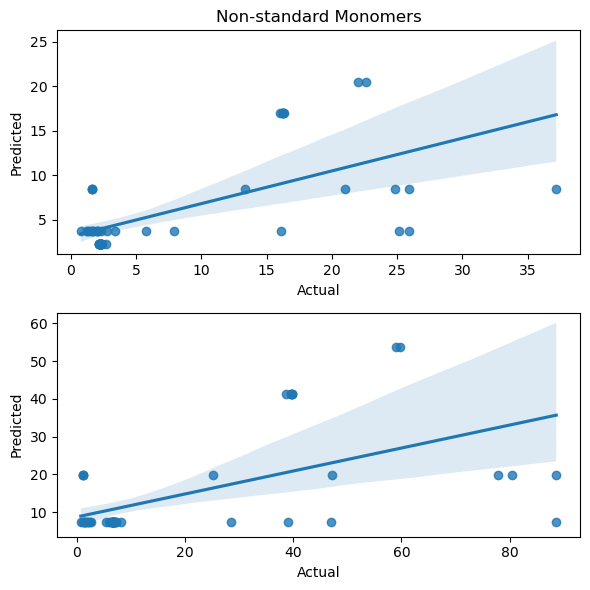

In [154]:
plot_results(nstds3, nstds4, 'Non-standard Monomers')

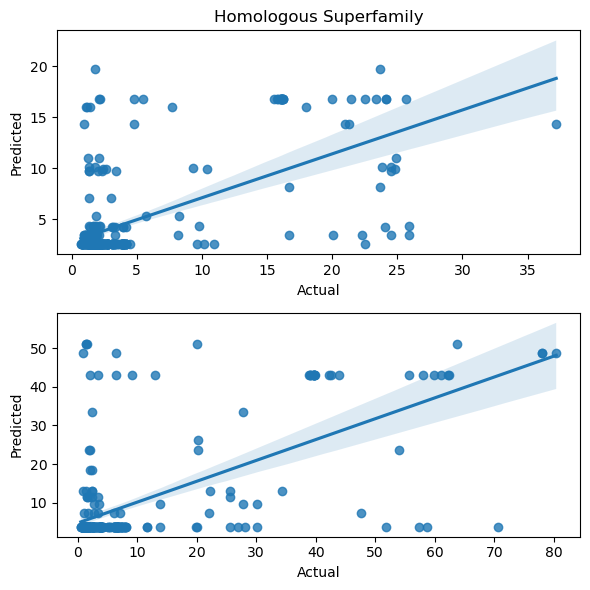

In [156]:
plot_results(superfam3, superfam4, 'Homologous Superfamily')

<Axes: >

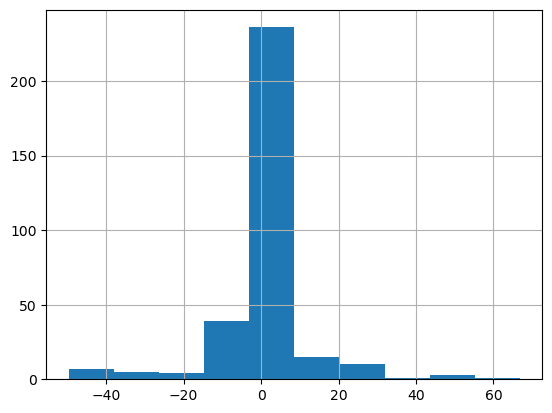

In [159]:
superfam4['residuals'] = superfam4['Actual'] - superfam4['Predicted']
superfam4['squared_error'] = superfam4['residuals'] ** 2
superfam4['residuals'].hist()

In [160]:
superfam4['squared_error'].mean()

152.6103817475508

In [139]:
nstds1_matrix, nstds2_matrix, nstds1_report, nstds2_report = fit_logistic_model(enstds, enstds1, enstds2)
non_p1_matrix, non_p2_matrix, non_p1_report, non_p2_report = fit_logistic_model(enon_p, enon_p1, enon_p2)
superfam1_matrix, superfam2_matrix, superfam1_report, superfam2_report = fit_logistic_model(esuperfam, esuperfam1, esuperfam2)
fam1_matrix, fam2_matrix, fam1_report, fam2_report = fit_logistic_model(efam, efam1, efam2)
conserved1_matrix, conserved2_matrix, conserved1_report, conserved2_report = fit_logistic_model(econserved, econserved1, econserved2)

/home/bjechow/anaconda3/envs/ranforest/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/bjechow/anaconda3/envs/ranforest/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/bjechow/anaconda3/envs/ranforest/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metr

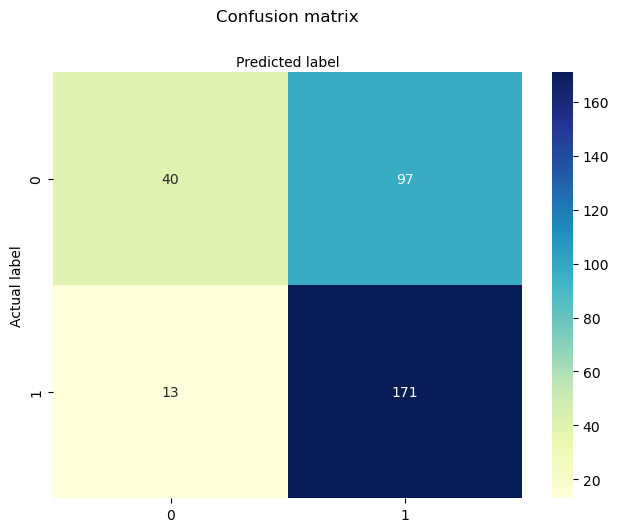

In [148]:
plot_confusion_matrix(superfam2_matrix)

In [149]:
print(superfam2_report)

                     precision    recall  f1-score   support

incorrect_structure       0.75      0.29      0.42       137
  correct_structure       0.64      0.93      0.76       184

           accuracy                           0.66       321
          macro avg       0.70      0.61      0.59       321
       weighted avg       0.69      0.66      0.61       321



In [ ]:
sns.histplot()

In [46]:
print(nstdsy2_pred, nstdsy2_test)

[ 7.44774545  7.44774545 19.8834     41.20578947  7.44774545  7.44774545
 19.8834      7.44774545 19.8834      7.44774545  7.44774545  7.44774545
  7.44774545  7.44774545  7.44774545  7.44774545  7.44774545  7.44774545
 41.20578947  7.44774545 41.20578947  7.44774545  7.44774545 19.8834
  7.44774545  7.44774545  7.44774545  7.44774545 19.8834     19.8834
  7.44774545 41.20578947  7.44774545  7.44774545  7.44774545  7.44774545
  7.44774545  7.44774545 53.84492     7.44774545  7.44774545 41.20578947
  7.44774545 41.20578947  7.44774545  7.44774545  7.44774545  7.44774545
 19.8834      7.44774545  7.44774545  7.44774545  7.44774545 53.84492
 19.8834      7.44774545] 33      6.475
108    38.969
240    80.408
259    39.803
154     1.534
9       6.595
146     1.082
203     2.465
144     1.210
155     1.234
221     1.268
92      6.662
222    28.409
209     1.972
42      6.635
210     2.554
66      6.526
90      6.713
119    38.741
142     5.354
262    39.770
268     7.228
206     0.721
238   

In [47]:
nstds1

,feature,coefficient
0,"""GUANOSINE-5'-DIPHOSPHATE""",16.684783
1,"""GUANOSINE-5'-TRIPHOSPHATE""",13.237358
2,"""ADENOSINE-5'-DIPHOSPHATE""",4.640663
3,"'S,S-(2-HYDROXYETHYL)THIOCYSTEINE'",-1.532555


In [ ]:
# score_nstds1, cnf_matrix_nstds1 = test_linear_model(nstdsX1_test, nstdsy1_test, nstds_model1)
# score_nstds2, cnf_matrix_nstds2 = test_linear_model(nstdsX2_test, nstdsy2_test, nstds_model2)

# score_non_p1, cnf_matrix_non_p1 = test_linear_model(non_pX1_test, non_py1_test, non_p_model1)
# score_non_p2, cnf_matrix_non_p2 = test_linear_model(non_pX2_test, non_py2_test, non_p_model2)

# score_superfam1, cnf_matrix_superfam1 = test_linear_model(superfamX1_test, superfamy1_test, superfam_model1)
# score_superfam2, cnf_matrix_superfam2 = test_linear_model(superfamX2_test, superfamy2_test, superfam_model2)

# score_fam1, cnf_matrix_fam1 = test_linear_model(famX1_test, famy1_test, fam_model1)
# score_fam2, cnf_matrix_fam2 = test_linear_model(famX2_test, famy2_test, fam_model2)

# score_cons1, cnf_matrix_cons1 = test_linear_model(consX1_test, consy1_test, cons_model1)
# score_cons2, cnf_matrix_cons2 = test_linear_model(consX2_test, consy2_test, cons_model2)

In [ ]:
print(score_nstds1)
plot_confusion_matrix(cnf_matrix_nstds1)

In [ ]:
nstds2

In [ ]:
non_p2

In [ ]:
superfam2

In [ ]:
fam1

In [ ]:
conserved1

In [ ]:
# X = ai.drop(columns=['complex_rmsd', '2_comp'])

# vif_data = pd.DataFrame()
# vif_data['feature'] = X.columns

# # Calculate VIF for each feature
# vif_data['VIF'] = [variance_inflation_factor(X.values, i)
#                    for i in range(len(X.columns))]

# vif_data

In [ ]:
# vif_data.sort_values(by='VIF', ascending=False)

# not_inf = vif_data[vif_data['VIF'] != np.inf]
# not_inf.sort_values(by='VIF', ascending=False)